# *Salix* and *Populus* sequence capture: quantifying sequence variation

Brian J. Sanderson

Last updated: 7 May 2020

Required R libraries: tidyverse, cowplot, stringr

Other required programs: [bcftools](https://samtools.github.io/bcftools/bcftools.html), [GATK](https://gatk.broadinstitute.org/hc/en-us), [vcftools](https://vcftools.github.io/index.html)

---

This analysis notebook describes the quantification of single nucleotide polymorphisms in the alignments generated in the notebook titled [*Salix* and *Populus* sequence capture: Assembly and Gene Trees](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/notebooks/Phylo_Trial_01_Assembly.ipynb).

**Note**: I used bcftools mpileup rather than GATK to identify variants because I wanted to have the non-variant sites (and their associated depths) included in the VCF for calculating &pi; (next notebook in series) so I could distinguish missing data (exclude from &pi; calculation) from sites with appropriate depth but no variation (include with &pi; calculation).

### Call SNPs using bcftools mpileup

```bams.txt``` is a list of the 13 BAM files generated by HybPiper (one for each of the *Populus*, *Salix*, and outgroup species).

```bash
bcftools mpileup -f phyloTargets.fasta -I -a FORMAT/AD -a FORMAT/DP -b bams.txt | bcftools call -m -Ov -o phyloTargets.mpileup.raw.vcf
```


### Extract some information about the SNP sites to estimate site filtering criteria

```bash
printf "CHROM\tPOS\tDP\tQUAL\tAC\tMQ\tRPB\tMQB\tICB\tHOB\n" > phyloTargets.mpileup.snps.table

bcftools query -f '%CHROM\t%POS\t%DP\t%QUAL\t%AC\t%MQ\t%RPB\t%MQB\t%ICB\t%HOB\n' phyloTargets.mpileup.raw.vcf >> phyloTargets.mpileup.snps.table

sed -i 's/Sapur\-//g' phyloTargets.mpileup.snps.table
```

**Note**: the sed line above removes the Sapur- prefix from the gene names, which is a hold-over from the alignments prepared by HybPiper. For mostly aesthetic reasons this bugged me so I removed it throughout downstream analyses. The important thing is it either needs to always be present or never be present because much of the code below joins different frames together using the gene name.

### Read the SNP table into R:

In [1]:
suppressMessages(library('cowplot'))
suppressMessages(library('stringr'))
suppressMessages(library('tidyverse'))

Import the snp table

In [2]:
VCFsnps <- suppressWarnings(read_delim('phyloTargets.mpileup.snps.table', na = c(".", "NA"), delim="\t"))

Parsed with column specification:
cols(
  CHROM = col_character(),
  POS = col_double(),
  DP = col_double(),
  QUAL = col_double(),
  AC = col_double(),
  MQ = col_double(),
  RPB = col_double(),
  MQB = col_double(),
  ICB = col_double(),
  HOB = col_double()
)



Calculte allele depth (AD) and quality / allele depth (QD) values:

In [3]:
VCFsnps$AD <- NA
VCFsnps$AD[!is.na(VCFsnps$AC)] <- unlist(lapply(type.convert(str_split(VCFsnps$AC[!is.na(VCFsnps$AC)], ",")), function(x) sum(x)))
VCFsnps$QD <- VCFsnps$QUAL / VCFsnps$AD

Set plotting parameters:

In [4]:
theme_set(theme_cowplot()); theme_update(plot.title = element_text(hjust = 0.5))

## Plot distributions of quality metrics from the VCF to be used for hard filtering criteria below

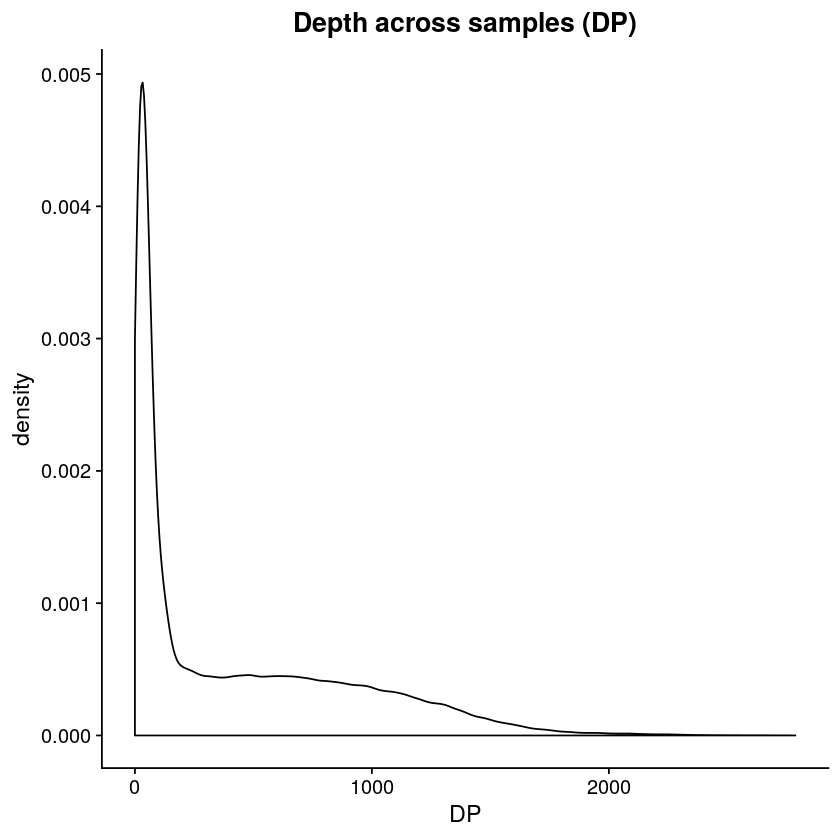

In [5]:
ggplot(VCFsnps, aes(x=DP)) + geom_density(alpha=0.3) +
    ggtitle("Depth across samples (DP)")

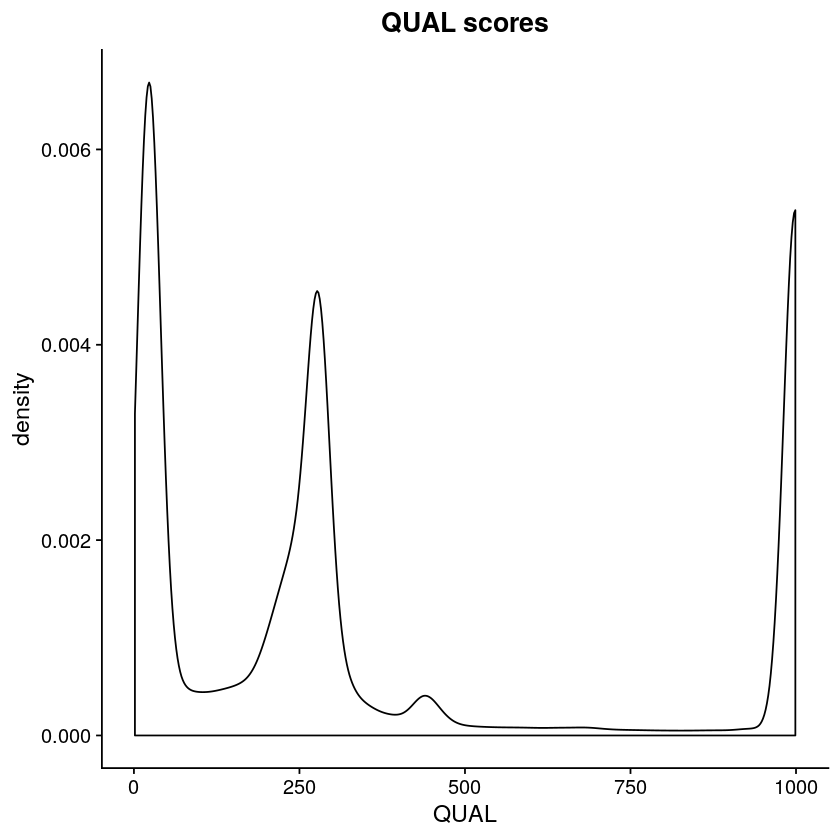

In [6]:
ggplot(VCFsnps, aes(x=QUAL)) + geom_density(alpha=.3) +
    ggtitle("QUAL scores")

Warning message:
“Removed 12079 rows containing non-finite values (stat_density).”


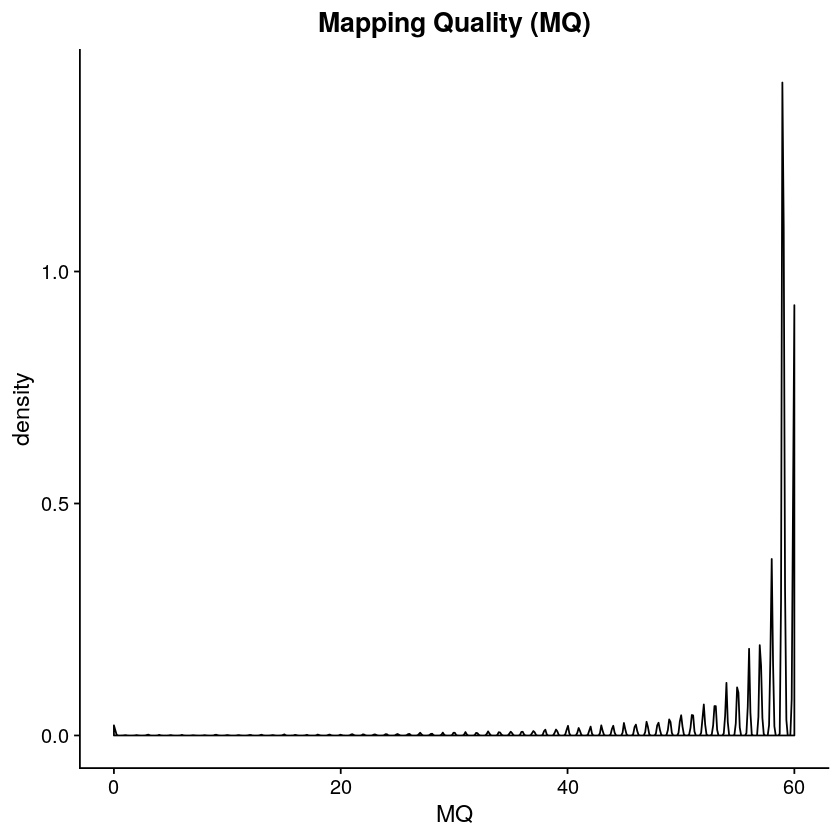

In [7]:
ggplot(VCFsnps, aes(x=MQ)) + geom_density(alpha=.3) +
ggtitle("Mapping Quality (MQ)")

Warning message:
“Removed 1693708 rows containing non-finite values (stat_density).”


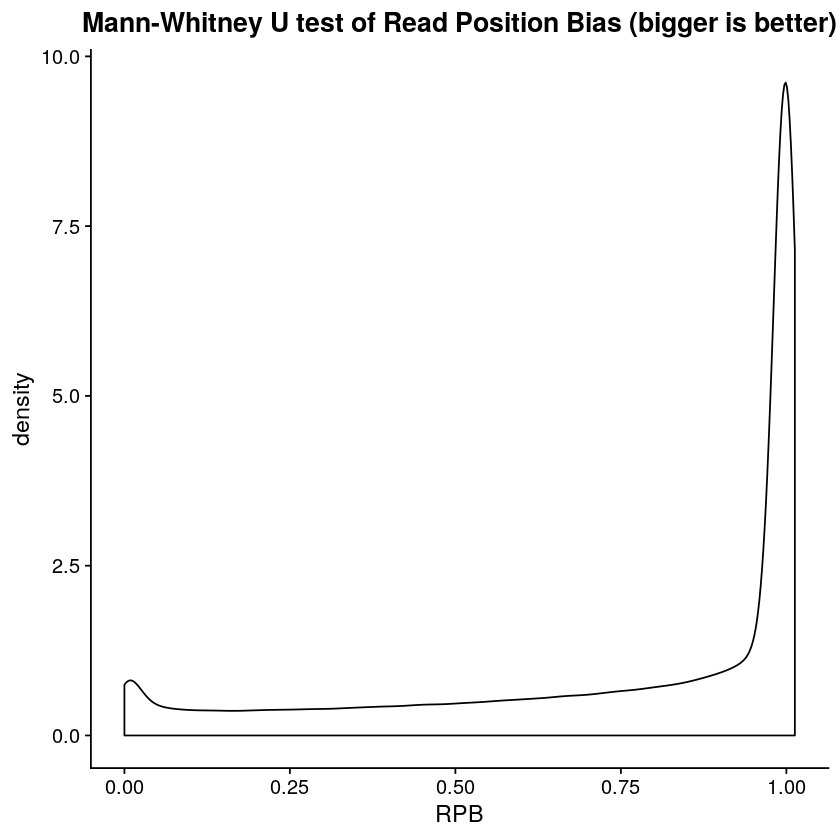

In [8]:
ggplot(VCFsnps, aes(x=RPB)) + geom_density(alpha=.3) +
    ggtitle("Mann-Whitney U test of Read Position Bias (bigger is better)")

Warning message:
“Removed 1693708 rows containing non-finite values (stat_density).”


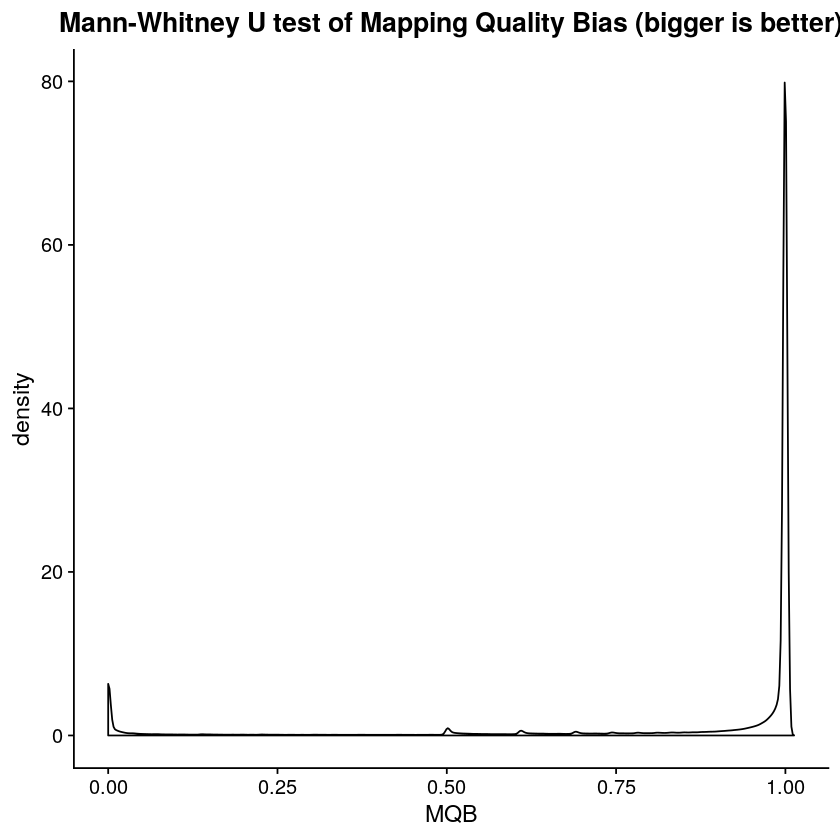

In [9]:
ggplot(VCFsnps, aes(x=MQB)) + geom_density(alpha=.3) +
    ggtitle("Mann-Whitney U test of Mapping Quality Bias (bigger is better)")

Warning message:
“Removed 2474560 rows containing non-finite values (stat_density).”


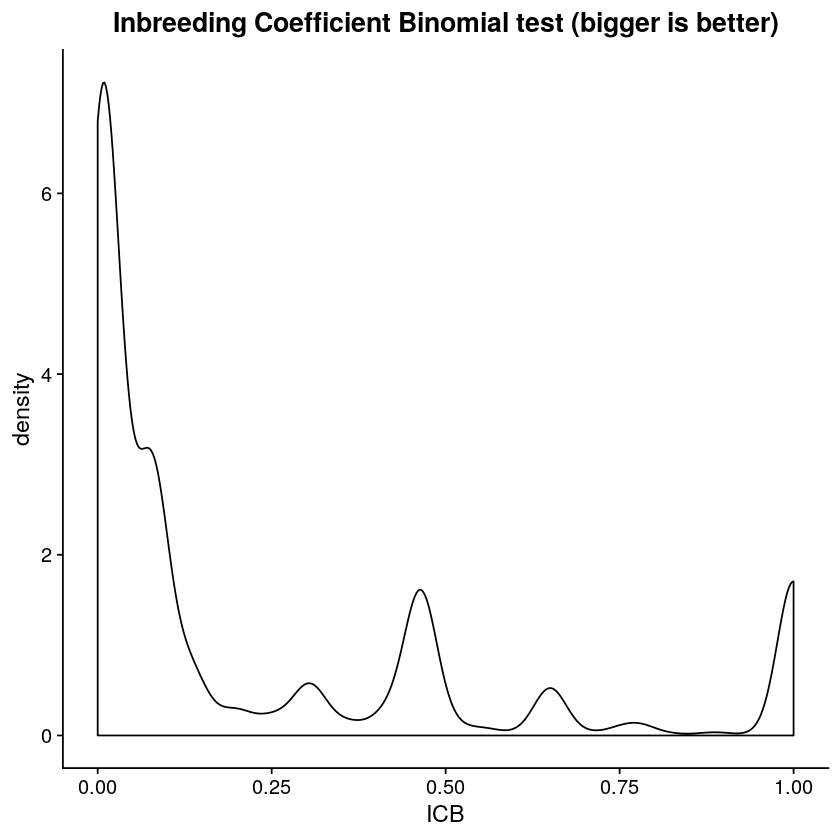

In [10]:
ggplot(VCFsnps, aes(x=ICB)) + geom_density(alpha=.3) +
    ggtitle("Inbreeding Coefficient Binomial test (bigger is better)")

Warning message:
“Removed 2474560 rows containing non-finite values (stat_density).”


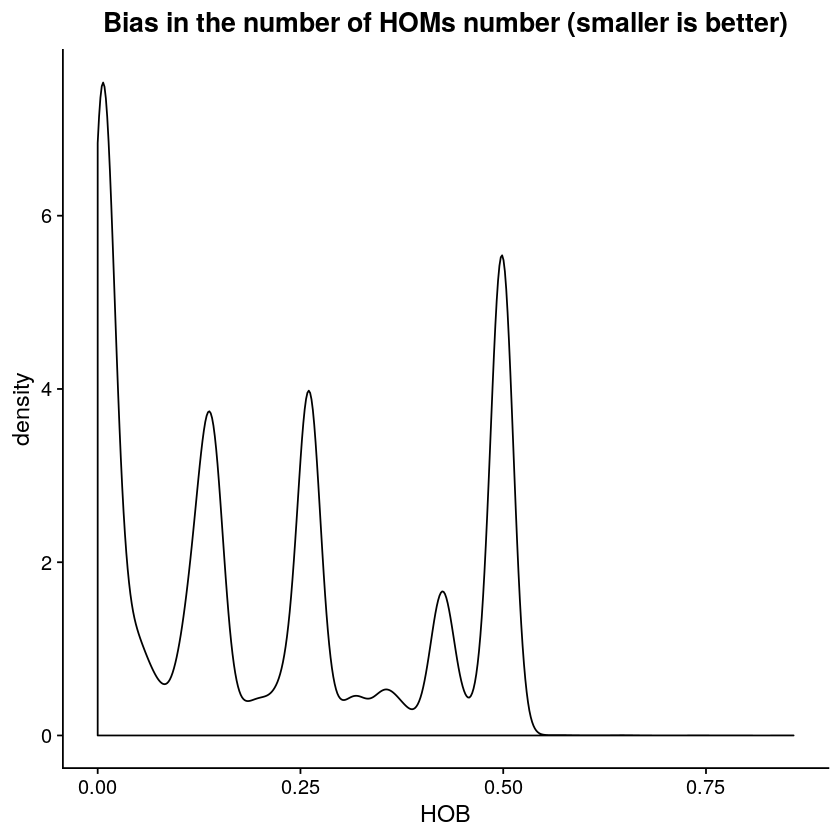

In [11]:
ggplot(VCFsnps, aes(x=HOB)) + geom_density(alpha=.3) +
    ggtitle("Bias in the number of HOMs number (smaller is better)")

### Quantify per depth per sample to determine criteria for depth filtering of genotypes

This will be used both to quantify read depths on- and off-target, as well as to determine hard-filtering criteria for SNPs

Create a table of depth values and genotypes

 ```bash
gatk VariantsToTable \
     -R phyloTargets.fasta \
     -V phyloTargets.mpileup.raw.vcf \
     -F CHROM -F POS -GF GT -GF DP \
     -O phyloTargets.mpileup.DP.table

sed -i 's/Sapur\-//g' phyloTargets.mpileup.DP.table
```

In R, determine quantiles for genotype depth for each sample:

In [12]:
all_frame <- read_delim("phyloTargets.mpileup.DP.table", delim = "\t")

Parsed with column specification:
cols(
  .default = col_character(),
  POS = col_double(),
  `I_polycarpa_WGS-2.sorted.bam.DP` = col_double(),
  `P_balsamifera_MGR-01.sorted.bam.DP` = col_double(),
  `P_balsamifera_MGR-04.sorted.bam.DP` = col_double(),
  P_mexicana_PM3.sorted.bam.DP = col_double(),
  P_mexicana_PM5.sorted.bam.DP = col_double(),
  `P_tremula_R01-01.sorted.bam.DP` = col_double(),
  `P_tremula_R04-01.sorted.bam.DP` = col_double(),
  S_exigua_SE002.sorted.bam.DP = col_double(),
  S_exigua_SE053.sorted.bam.DP = col_double(),
  S_nigra_SG037.sorted.bam.DP = col_double(),
  S_nigra_SG051.sorted.bam.DP = col_double(),
  S_phlebophylla_SP15M.sorted.bam.DP = col_double(),
  S_phlebophylla_SP7F.sorted.bam.DP = col_double()
)

See spec(...) for full column specifications.



```probeExons.txt``` is a table of the coordinates within gene sequences that were targeted by the sequence capture baits. I use this to quantify on- and off-target capture percentages below.

In [13]:
on_target <- read_delim("probeExons.txt", delim = "\t", col_names = F) %>% select(gene = X1, start = X2, stop = X3)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double()
)



Create a convenience frame for summarizing on-target reads

In [14]:
on_target %>%
    rowwise() %>%
    do(tibble(CHROM = .$gene, POS = .$start:.$stop)) %>%
    arrange(CHROM) %>%
    mutate(., 'I_polycarpa_WGS-2.sorted.bam' = NA,
              'P_balsamifera_MGR-01.sorted.bam' = NA,
              'P_balsamifera_MGR-04.sorted.bam' = NA,
              'P_mexicana_PM3.sorted.bam' = NA,
              'P_mexicana_PM5.sorted.bam' = NA,
              'P_tremula_R01-01.sorted.bam' = NA,
              'P_tremula_R04-01.sorted.bam' = NA,
              'S_exigua_SE002.sorted.bam' = NA,
              'S_exigua_SE053.sorted.bam' = NA,
              'S_nigra_SG037.sorted.bam' = NA,
              'S_nigra_SG051.sorted.bam' = NA,
              'S_phlebophylla_SP15M.sorted.bam' = NA, 
              'S_phlebophylla_SP7F.sorted.bam' = NA) %>%
    gather(., key = "library", value = "dummy",
              'I_polycarpa_WGS-2.sorted.bam',
              'P_balsamifera_MGR-01.sorted.bam',
              'P_balsamifera_MGR-04.sorted.bam',
              'P_mexicana_PM3.sorted.bam',
              'P_mexicana_PM5.sorted.bam',
              'P_tremula_R01-01.sorted.bam',
              'P_tremula_R04-01.sorted.bam',
              'S_exigua_SE002.sorted.bam',
              'S_exigua_SE053.sorted.bam',
              'S_nigra_SG037.sorted.bam',
              'S_nigra_SG051.sorted.bam',
              'S_phlebophylla_SP15M.sorted.bam',
              'S_phlebophylla_SP7F.sorted.bam') %>% select(., -dummy) %>% ungroup() -> on_target_skeleton

Convert the columns containing the site read depths into a long-form data frame

In [15]:
select(all_frame, CHROM, POS, contains(".DP")) %>%
gather(., "library", "counts", contains(".DP")) %>%
mutate(., library = gsub(".DP", "", library)) -> depth_frame

Convert the columns containing the site genotypes into a long-form data frame

In [16]:
select(all_frame, CHROM, POS, contains(".GT")) %>%
gather(., "library", "genotype", contains(".GT")) %>%
mutate(., library = gsub(".GT", "", library)) -> gt_frame

Join the depth and genotype frames

In [17]:
describe_frame <- left_join(depth_frame, gt_frame, by = c("CHROM" = "CHROM", "POS" = "POS", "library" = "library"))

Change the read count values for sites with no-call genotypes to NA values

In [18]:
mutate(describe_frame, counts = replace(counts, genotype == "./.", NA)) -> describe_frame_sub

Populate the on-target frame with the appropriate read depths, and replace NA values with read counts of 0

In [19]:
on_target_frame <- left_join(on_target_skeleton, describe_frame_sub) %>% 
    mutate(., counts = replace(counts, is.na(counts), 0))

Joining, by = c("CHROM", "POS", "library")


Create an off-target frame by looking for an anti-join between our on-target frame and the depth frame

In [20]:
off_target_frame <- anti_join(describe_frame_sub, on_target_frame, by = c("CHROM" = "CHROM",
                                                                          "POS" = "POS"))

### Summarize the depth across all sites at various quantiles

In [21]:
summarise(describe_frame_sub, "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

5%,25%,50%,75%,99%,MAX,mean,sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,19,42,70,174,285,32.1246,1.931347


### Summarize the depth across all sites at various quantiles, grouped by library

In [22]:
group_by(describe_frame_sub, library) %>%
summarise(., "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

library,5%,25%,50%,75%,99%,MAX,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I_polycarpa_WGS-2.sorted.bam,4,23,40,61,154,285,34.04619,1.418709
P_balsamifera_MGR-01.sorted.bam,2,14,32,53,130,250,24.94819,1.750205
P_balsamifera_MGR-04.sorted.bam,2,17,41,67,164,252,30.28407,1.933409
P_mexicana_PM3.sorted.bam,2,20,47,78,179,244,34.52968,2.007412
P_mexicana_PM5.sorted.bam,2,21,49,81,187,247,35.75445,2.031589
P_tremula_R01-01.sorted.bam,2,17,39,65,163,270,29.26711,1.935673
P_tremula_R04-01.sorted.bam,2,14,32,54,140,267,24.99873,1.811809
S_exigua_SE002.sorted.bam,2,26,66,107,197,251,44.85426,2.224323
S_exigua_SE053.sorted.bam,2,21,50,82,154,244,35.79224,1.986727


### Summarize the depth across on-target sites at various quantiles

In [23]:
summarise(ungroup(on_target_frame), "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

5%,25%,50%,75%,99%,MAX,mean,sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,32,55,82,185,285,44.64718,1.608228


### Summarize the depth across off-target sites at various quantiles, grouped by library

In [24]:
group_by(ungroup(on_target_frame), library) %>%
summarise(., "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

library,5%,25%,50%,75%,99%,MAX,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I_polycarpa_WGS-2.sorted.bam,11,32,50,71,169,285,44.38664,1.142870
P_balsamifera_MGR-01.sorted.bam,4,24,41,61,138,250,33.14550,1.559422
P_balsamifera_MGR-04.sorted.bam,5,31,53,77,174,252,42.06391,1.599174
P_mexicana_PM3.sorted.bam,5,35,61,89,187,244,47.43916,1.699901
P_mexicana_PM5.sorted.bam,5,37,63,92,197,247,49.28549,1.715783
P_tremula_R01-01.sorted.bam,4,29,51,74,174,270,39.94162,1.675730
P_tremula_R04-01.sorted.bam,4,24,42,62,150,267,33.72002,1.597830
S_exigua_SE002.sorted.bam,9,53,86,121,206,251,67.10618,1.610152
S_exigua_SE053.sorted.bam,7,40,66,92,161,244,50.92572,1.568659


### Summarize the depth across off-target sites at various quantiles

In [25]:
summarise(ungroup(off_target_frame), "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

5%,25%,50%,75%,99%,MAX,mean,sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,18,37,118,274,14.47625,2.101949


### Summarize the depth across off-target sites at various quantiles, grouped by library

In [26]:
group_by(ungroup(off_target_frame), library) %>%
summarise(., "5%" = quantile(counts, 0.05, na.rm =T),
                              "25%" = quantile(counts, 0.25, na.rm =T),
                              "50%" = quantile(counts, 0.5, na.rm =T),
                              "75%" = quantile(counts, 0.75, na.rm =T),
                              "99%" = quantile(counts, 0.99, na.rm =T),
                              "MAX" = max(counts, na.rm = T), 
                              "mean" = exp(mean(log(counts + 1), na.rm =T)) - 1,
                              "sd" = exp(sd(log(counts + 1), na.rm =T)) - 1)

library,5%,25%,50%,75%,99%,MAX,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I_polycarpa_WGS-2.sorted.bam,3,17,33,53,142,274,27.422467,1.580053
P_balsamifera_MGR-01.sorted.bam,1,4,12,25,71,145,10.463435,1.785212
P_balsamifera_MGR-04.sorted.bam,1,4,14,31,88,165,11.936904,2.022761
P_mexicana_PM3.sorted.bam,1,5,16,36,99,176,13.396000,2.158038
P_mexicana_PM5.sorted.bam,1,5,17,37,103,178,13.920916,2.168239
P_tremula_R01-01.sorted.bam,1,4,14,30,92,250,11.705342,1.994594
P_tremula_R04-01.sorted.bam,1,4,12,25,72,252,10.393218,1.802449
S_exigua_SE002.sorted.bam,1,5,19,44,138,238,15.257419,2.434825
S_exigua_SE053.sorted.bam,1,5,15,33,103,189,12.806830,2.083405


Calculate sequence capture efficiency as the proportion of sites within the on-target sequences that have > 10 reads mapped

In [27]:
group_by(on_target_frame, library, CHROM) %>%
    summarize(., total_sites = n(),
                 mapped_sites = sum(counts > 10),
                 prop_mapped = mapped_sites / total_sites) -> efficiency_frame

In [28]:
ungroup(efficiency_frame) %>%
    group_by(library) %>%
    summarize(., x0 = sum(prop_mapped > 0),
                 x25 = sum(prop_mapped >= 0.25),
                 x50 = sum(prop_mapped >= 0.50),
                 x75 = sum(prop_mapped >= 0.75),
                 x100 = sum(prop_mapped == 1))

library,x0,x25,x50,x75,x100
<chr>,<int>,<int>,<int>,<int>,<int>
I_polycarpa_WGS-2.sorted.bam,971,970,966,944,123
P_balsamifera_MGR-01.sorted.bam,972,971,960,884,122
P_balsamifera_MGR-04.sorted.bam,972,972,965,915,145
P_mexicana_PM3.sorted.bam,972,972,964,917,140
P_mexicana_PM5.sorted.bam,972,972,967,913,142
P_tremula_R01-01.sorted.bam,971,970,960,907,134
P_tremula_R04-01.sorted.bam,971,969,956,876,122
S_exigua_SE002.sorted.bam,969,969,966,937,229
S_exigua_SE053.sorted.bam,969,969,964,928,195


### Perform hard filtering of SNP sites

I've made modifications to the criteria used [here](http://evodify.com/gatk-the-best-practice-for-genotype-calling-in-a-non-model-organism/) and [here](https://gatkforums.broadinstitute.org/gatk/discussion/6925/understanding-and-adapting-the-generic-hard-filtering-recommendations). 

```bash
bcftools filter -e'%QUAL<20 || MQ < 40 || MQB < 0.8' phyloTargets.mpileup.raw.vcf > phyloTargets.mpileup.filtered.vcf
```

### Filter genotypes by depth criteria

Based on the quantile distributions of reads across the libraries, I decided to filter for a minimum of 10 reads supporting a genotype, and a maximum of 180 reads supporting a genotype.

```bash
gatk VariantFiltration \
    -R phyloTargets.fasta \
    -V phyloTargets.mpileup.filtered.vcf \
    --genotype-filter-expression "DP < 4 || DP > 180" \
    --genotype-filter-name "DP_4-180" \
    -O phyloTargets.mpileup.filtered.DP.vcf
```

From the genotype-depth-filtered VCF, set all genotypes that do not pass the filter to have no call genotypes (./.)

```bash
gatk SelectVariants \
    -R phyloTargets.fasta \
    -V phyloTargets.mpileup.filtered.DP.vcf \
    --set-filtered-gt-to-nocall TRUE \
    -O phyloTargets.mpileup.filtered.DP.nocall.vcf
```

### Compress and index the VCF to help with diversity calculations

```bash
sed -i 's/\t\.\:/\t\.\/\.\:/g' phyloTargets.mpileup.filtered.DP.nocall.recode.vcf
bgzip phyloTargets.mpileup.filtered.DP.nocall.recode.vcf
tabix phyloTargets.mpileup.filtered.DP.nocall.recode.vcf.gz
```